In [1]:
import warnings
warnings.filterwarnings("ignore")
import json
import os
import random
import torch
import tqdm
from PIL import Image
from pathlib import Path
from collections import defaultdict
import sys
sys.path[0] = os.path.abspath('..')
import torchvision.transforms as transforms
import argparse
from torchvision.transforms.functional import InterpolationMode
from extras_ import convert_sents_to_features, BertLayer
from finetune import ContextualBLIP
from blip_finetune import ContextualBLIP as BLIP
from models.contextual_new import Adapter_BLIP
from volta_src.config import BertConfig
import yaml
import torch.nn as nn
from utils import pre_caption

parser = argparse.ArgumentParser()
parser.add_argument('--valid_descr_path', type=str, default='dataset/valid_data.json')
parser.add_argument('--train_descr_path', type=str, default='dataset/train_data.json')
parser.add_argument('--imgs_path', type=str, default='dataset/image-sets')
parser.add_argument("--add_input", action="store_true",default=True)
parser.add_argument("--positional", action="store_true",default=True)
parser.add_argument("--transformer_layers", default=2, type=int)
parser.add_argument("--all_pos", action="store_true",default=False)
parser.add_argument("-a", "--activation", default='relu')
parser.add_argument("-s", "--logit_scale", default=1000)
parser.add_argument("--frozen_blip", action="store_true",default=True)
args = parser.parse_args([])

In [2]:
# IMAGECODE
img_dirs = args.imgs_path
valid_data = json.load(open(args.valid_descr_path, 'r'))
valid = []
for img_dir, data in valid_data.items():
    for img_idx, text in data.items():
        valid.append((img_dir, img_idx, text))
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'DEVICE USED: {device}')

DEVICE USED: cuda


In [3]:
# 模型路径
blip_model_path = 'checkpoints/1/blip_finetuned_model.pt'
adater_blip_model_path = '4_0.25_36_0.3493_18.pt'

bert_config = json.load(open('vilbert-and-bert-config.json', 'r'))

adater_blip = ContextualBLIP(bert_config, args,pretrain=False).cuda()
checkpoint = torch.load(adater_blip_model_path)
adater_blip.load_state_dict(checkpoint['model_state_dict'],strict= False)

blip = BLIP(bert_config, args,pretrain=False).cuda()
checkpoint = torch.load(blip_model_path)
blip.load_state_dict(checkpoint['model_state_dict'],strict= False)

adater_blip.cuda()
adater_blip.eval()
blip.cuda()
blip.eval()

preprocess = transforms.Compose([
    transforms.Resize((224,224),interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
    ]) 

tf params: 14175744


In [125]:
from matplotlib import pyplot as plt 
import numpy as np
np.set_printoptions(precision = 3)

def find_by_text(dataset, text):
    for img_dir, img_idx, t in tqdm.tqdm(dataset):
        if text == t:
            return img_dir,img_idx,text
    return False

def plt_logits(logits):
    plt.imshow(logits,cmap='Greys')
    ax = plt.gca()
    
    plt.axis('off')
    for i in range(logits.size):
        text = plt.text(i,0, str(round(logits[0,i],3)), ha="center", va="center", color="w")
        rect = plt.Rectangle((-0.5+i,-0.51),1,1,fill=False,linewidth=1)
        ax.add_patch(rect)
    #plt.tight_layout()

In [5]:
caption = 'the transition image into the one of the lady in blue from the one where bags where hang up'
caption2 = 'There is picture overlay with the first picture having slightly more visibility than the second. '
caption3 = 'Her eyes are closed.'

ground truth: 8 blip: 8 ours: 8
Her eyes are closed.


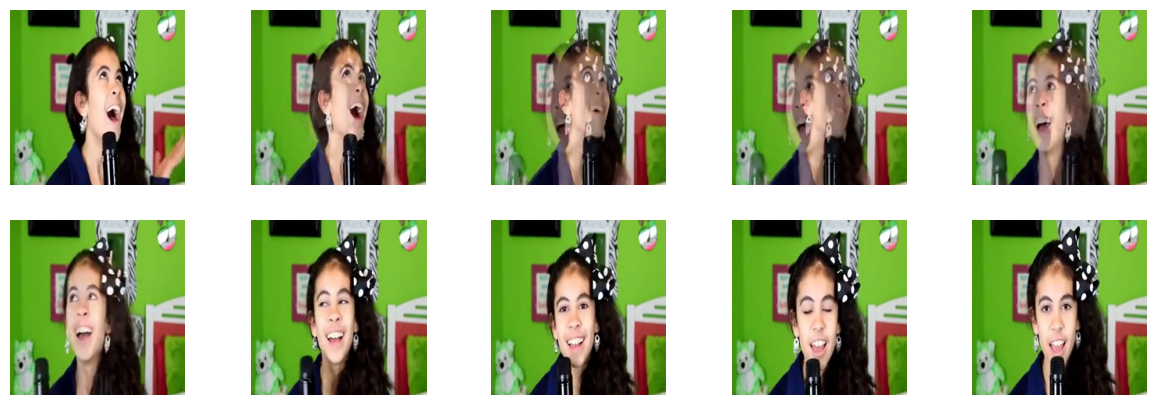

In [74]:
random.shuffle(valid)
with torch.no_grad():
    for img_dir, img_idx, text_ in valid:
        #img_dir, img_idx, text_ = find_by_text(valid,caption2)

        text = [pre_caption(text_)]
        img_idx = int(img_idx)
        img_files = list((Path(img_dirs) / img_dir).glob("*.jpg"))
        img_files = sorted(img_files, key=lambda x: int(str(x).split('/')[-1].split('.')[0][3:]))
        images = [Image.open(photo_file).convert("RGB") for photo_file in img_files]
        preprocess = transforms.Compose([
            transforms.Resize((224,224),interpolation=InterpolationMode.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
            ])  
        images = [preprocess(image) for image in images]
        image = torch.stack(images).to(device)
        
        if "open-images" in str(img_dir):
            pos_mask = torch.zeros((10, 1)).cuda()
        else:
            pos_mask = torch.ones((10, 1)).cuda()
        break

from matplotlib import pyplot as plt
import numpy as np

fig, ax = plt.subplots(2,5,figsize=(15,5))

images = [Image.open(photo_file).convert("RGB").resize((224,224)) for photo_file in img_files]
for i,img in enumerate(images):
    ax[i//5,i%5].imshow(np.array(img))
    ax[i//5,i%5].axis('off')
fig.show()

with torch.no_grad():
    logits1 = blip(image, text,pos_mask)
    pred1 = torch.argmax(logits1.squeeze()).squeeze()
    logits2,attn2 = adater_blip(image, text,pos_mask,output_attn=True)
    pred2 = torch.argmax(logits2.squeeze()).squeeze()
    print("ground truth:",img_idx,"blip:",pred1.cpu().item(),'ours:',pred2.cpu().item())
    print(text_)
    logits1 = torch.softmax(logits1,dim=1).reshape(-1)
    logits2 = torch.softmax(logits2,dim=1).reshape(-1)
    logits1 = logits1.cpu().numpy().reshape(1,-1)
    logits2 = logits2.cpu().numpy().reshape(1,-1)


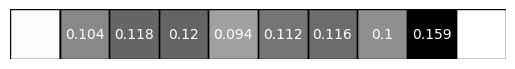

In [126]:
plt_logits(logits1)


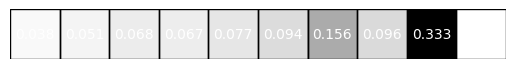

In [127]:
plt_logits(logits2)

### Case Study 想法
上面的文本存在几个判断条件，分别为"the lady in blue"、"bags were hang up"和"the transition image"
通过模型输出各图的logits，我们可以体现模型是否真正关注到这些判定信息
下面分别用三个子条件的文本进行检索，可以看到除了"the lady in blue"效果不好，另两个效果都很不错

In [ ]:
subcaption1 = "the lady in blue"
subcaption2 = "bags were hang up"
subcaption3 = "It's a little blurry."
subcaption4 = "The top edge of the paper is right against the top of the frame."
subcaption5 = "The person on the left has their mouth still closed."

In [ ]:
with torch.no_grad():
    text = [pre_caption(subcaption4)]

    logits1,attn1 = blip(image, text,pos_mask,output_attn=True)
    pred1 = torch.argmax(logits.squeeze()).squeeze()

    logits2,attn2 = adater_blip(image, text,pos_mask,output_attn=True)
    pred2 = torch.argmax(logits.squeeze()).squeeze()
    print("ground truth:",img_idx,'ours:',pred2.cpu().item())
    print(text)
    print(torch.softmax(logits1,dim=1))
    print(torch.softmax(logits2,dim=1))

ground truth: 3 ours: 3
['the top edge of the paper is right against the top of the frame']
tensor([[[0.0452],
         [0.0979],
         [0.1207],
         [0.1240],
         [0.1085],
         [0.1273],
         [0.1125],
         [0.1243],
         [0.0938],
         [0.0458]]], device='cuda:0')
tensor([[[0.0497],
         [0.0711],
         [0.0995],
         [0.0998],
         [0.1522],
         [0.1359],
         [0.1370],
         [0.1189],
         [0.1005],
         [0.0355]]], device='cuda:0')


In [ ]:
with torch.no_grad():
    text = [pre_caption(subcaption5)]
    logits1,attn1 = blip(image, text,pos_mask,output_attn=True)
    pred1 = torch.argmax(logits.squeeze()).squeeze()
    
    logits2,attn2 = adater_blip(image, text,pos_mask,output_attn=True)
    pred2 = torch.argmax(logits.squeeze()).squeeze()
    print("ground truth:",img_idx,'ours:',pred2.cpu().item())
    print(text)
    print(torch.softmax(logits1,dim=1))
    print(torch.softmax(logits2,dim=1))

ground truth: 5 ours: 5
['the person on the left has their mouth still closed']
tensor([[[0.0452],
         [0.0972],
         [0.1217],
         [0.1250],
         [0.1083],
         [0.1273],
         [0.1119],
         [0.1235],
         [0.0939],
         [0.0460]]], device='cuda:0')
tensor([[[0.0508],
         [0.0576],
         [0.1277],
         [0.1713],
         [0.1423],
         [0.1845],
         [0.0892],
         [0.1017],
         [0.0453],
         [0.0296]]], device='cuda:0')


In [ ]:
with torch.no_grad():
    text = [pre_caption(subcaption3)]
    logits1,attn1 = blip(image, text,pos_mask,output_attn=True)
    pred1 = torch.argmax(logits.squeeze()).squeeze()
    logits2,attn2 = adater_blip(image, text,pos_mask,output_attn=True)
    pred2 = torch.argmax(logits.squeeze()).squeeze()
    print("ground truth:",img_idx,'ours:',pred2.cpu().item())
    print(text)
    print(torch.softmax(logits1,dim=1))
    print(torch.softmax(logits2,dim=1))

ground truth: 3 ours: 7
['its a little blurry']
tensor([[[0.0453],
         [0.0981],
         [0.1205],
         [0.1238],
         [0.1086],
         [0.1272],
         [0.1126],
         [0.1243],
         [0.0938],
         [0.0458]]], device='cuda:0')
tensor([[[0.0656],
         [0.0662],
         [0.1773],
         [0.1782],
         [0.1235],
         [0.1033],
         [0.0974],
         [0.0998],
         [0.0562],
         [0.0324]]], device='cuda:0')
